## Import

In [1]:
!nvidia-smi

Tue Nov 29 08:58:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  CUDA GPU            Off  | 00000000:C1:00.0 Off |                  Off |
| 30%   28C    P8     7W / 230W |     48MiB /  3070MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install -q tsaug

In [3]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Hyperparameter Setting

In [5]:
CFG = {
    'X_RANGE': 7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-2,
    'BATCH_SIZE': 128,
    'SEED': 41
}

## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [7]:
path = '/home/work/dacon/'

train_df = pd.read_csv(path+'data/train.csv')

In [8]:
train_df.head()

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308


In [9]:
train_df['일시'].min(), train_df['일시'].max()

(20180101, 20211231)

In [10]:
train_df.iloc[:, 1:].corr()

,광진구,동대문구,성동구,중랑구
광진구,1.000000,0.931677,0.982757,0.940734
동대문구,0.931677,1.000000,0.944432,0.986240
성동구,0.982757,0.944432,1.000000,0.957428
중랑구,0.940734,0.986240,0.957428,1.000000


## Data Visualization

In [11]:
def get_view_df(df, target):
    viewd = df[['일시', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    print(target)
    sns.set(rc={'figure.figsize':(30, 8)})
    sns.lineplot(x='index', y=target, data=viewd)
    plt.show()

광진구


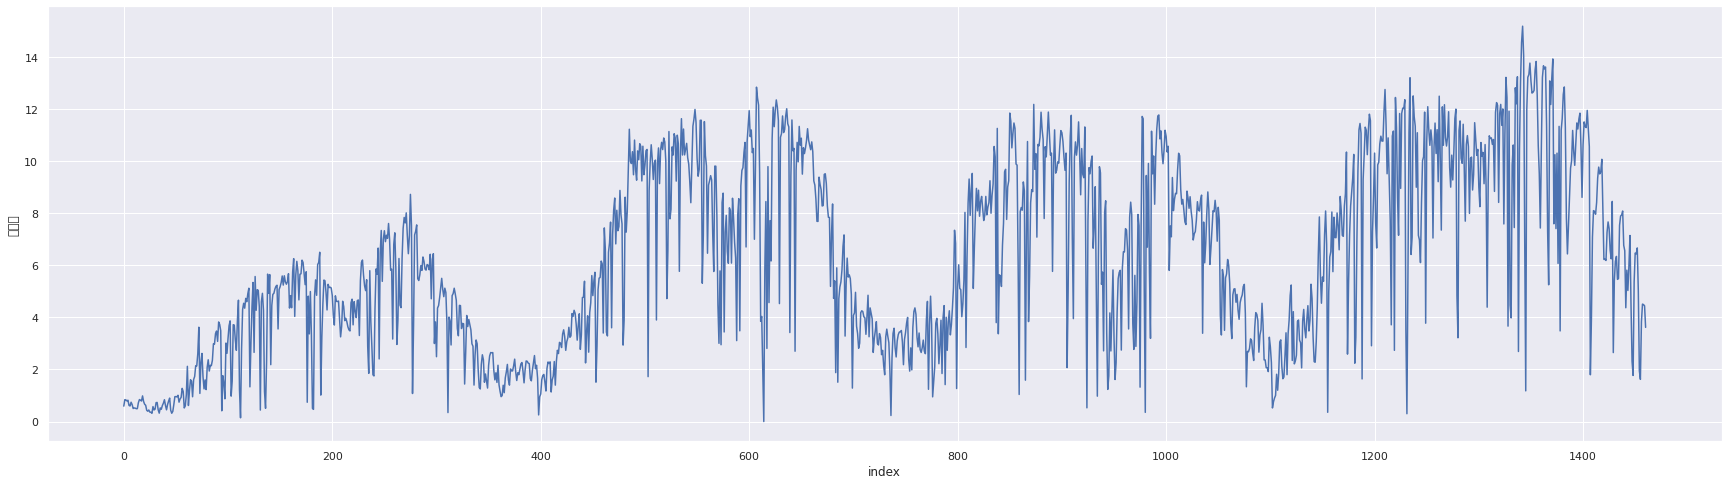

동대문구


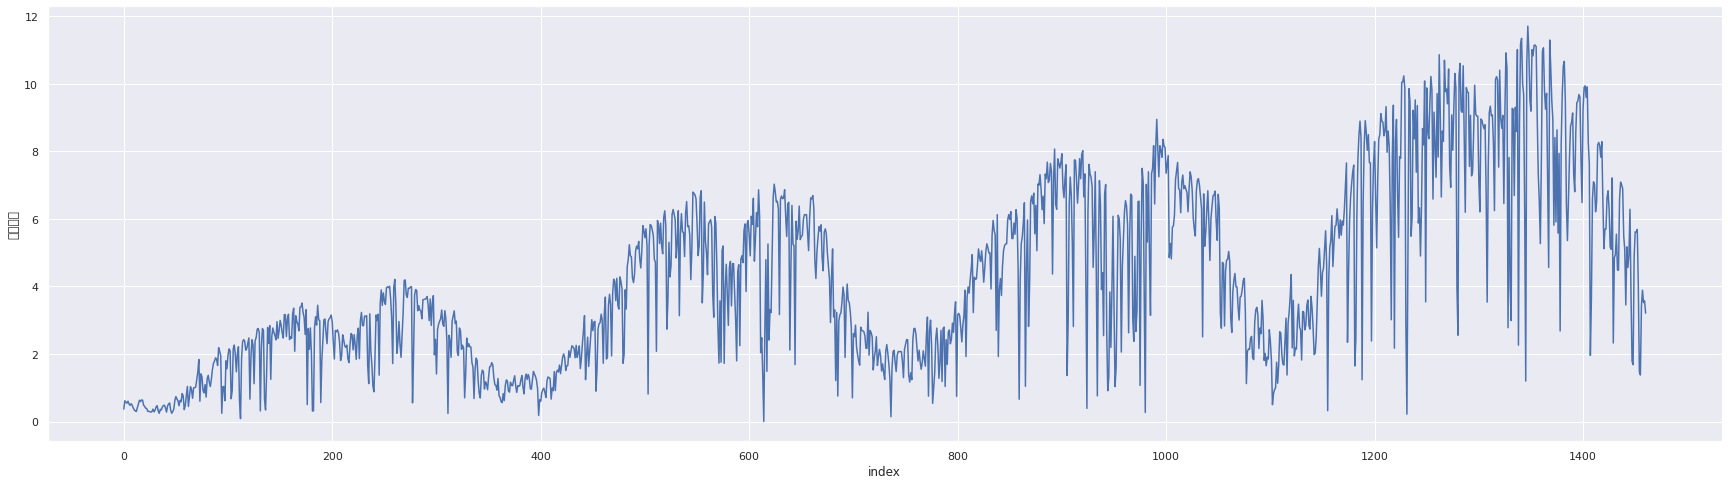

성동구


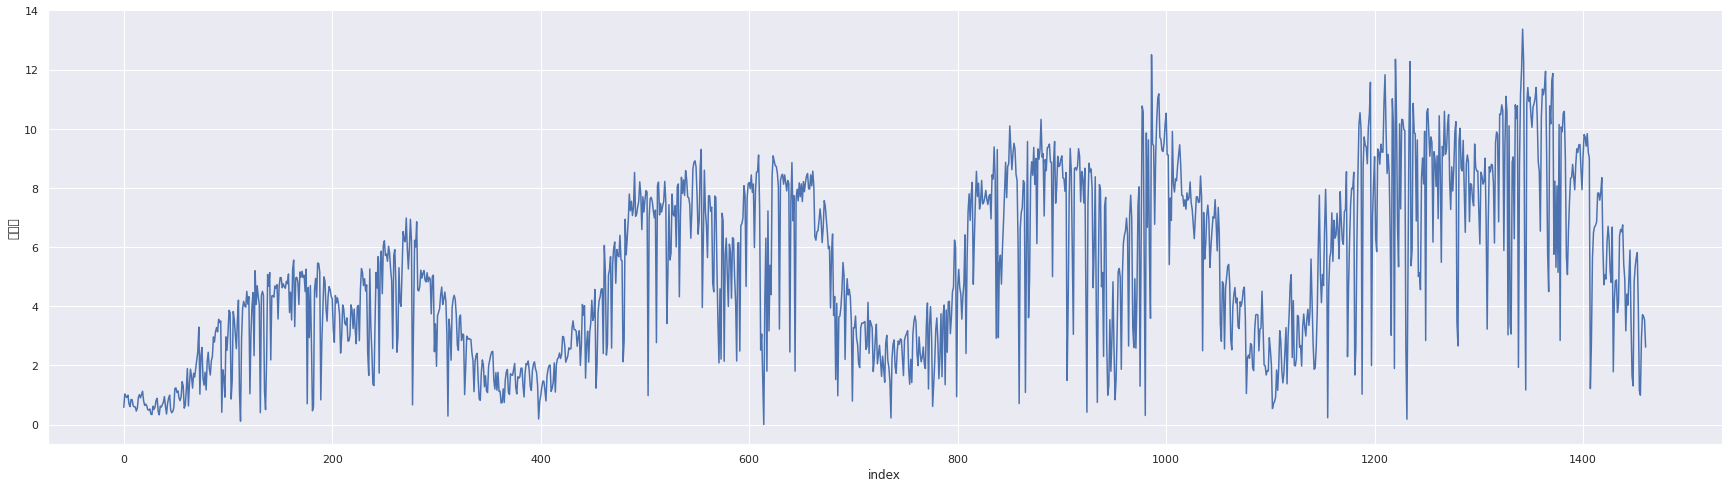

중랑구


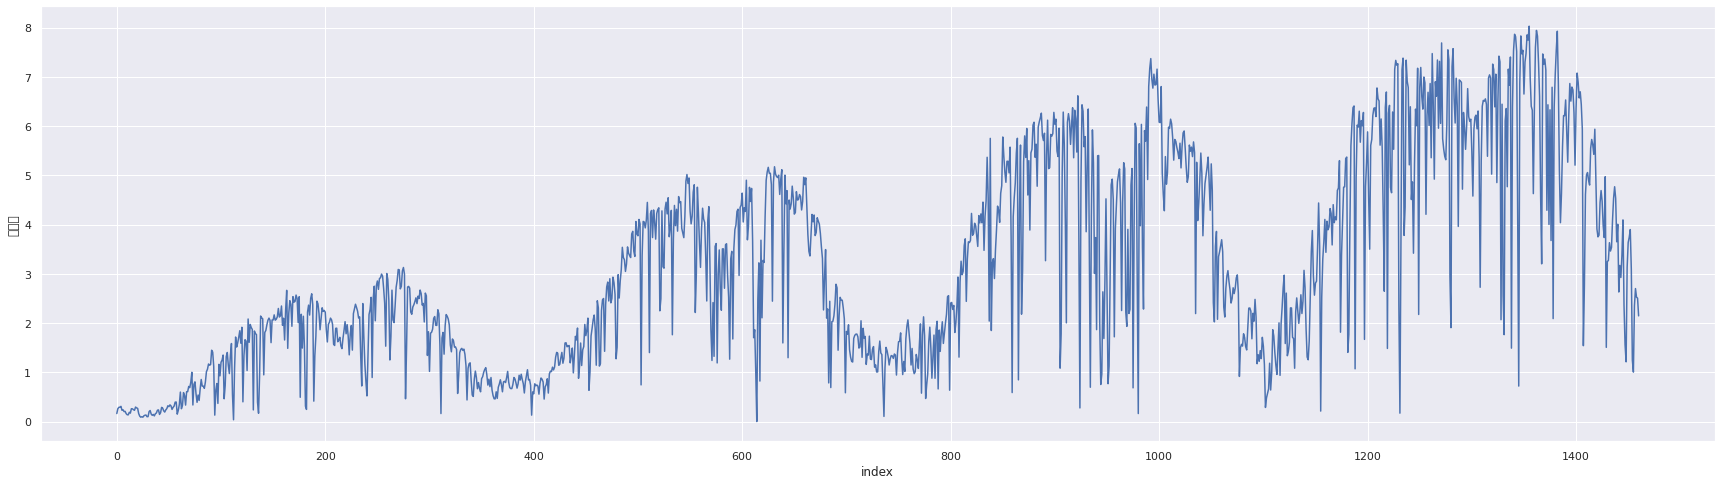

In [12]:
get_view_df(train_df, '광진구')
get_view_df(train_df, '동대문구')
get_view_df(train_df, '성동구')
get_view_df(train_df, '중랑구')

## Augmentation

In [13]:
import tsaug
from tsaug import AddNoise, Convolve, Crop, Drift, Pool, Quantize, Resize, Reverse, TimeWarp
from tsaug.visualization import plot

In [14]:
X = np.arange(len(train_df))
Y1 = np.array(train_df['광진구'].tolist())
Y2 = np.array(train_df['동대문구'].tolist())
Y3 = np.array(train_df['성동구'].tolist())
Y4 = np.array(train_df['중랑구'].tolist())

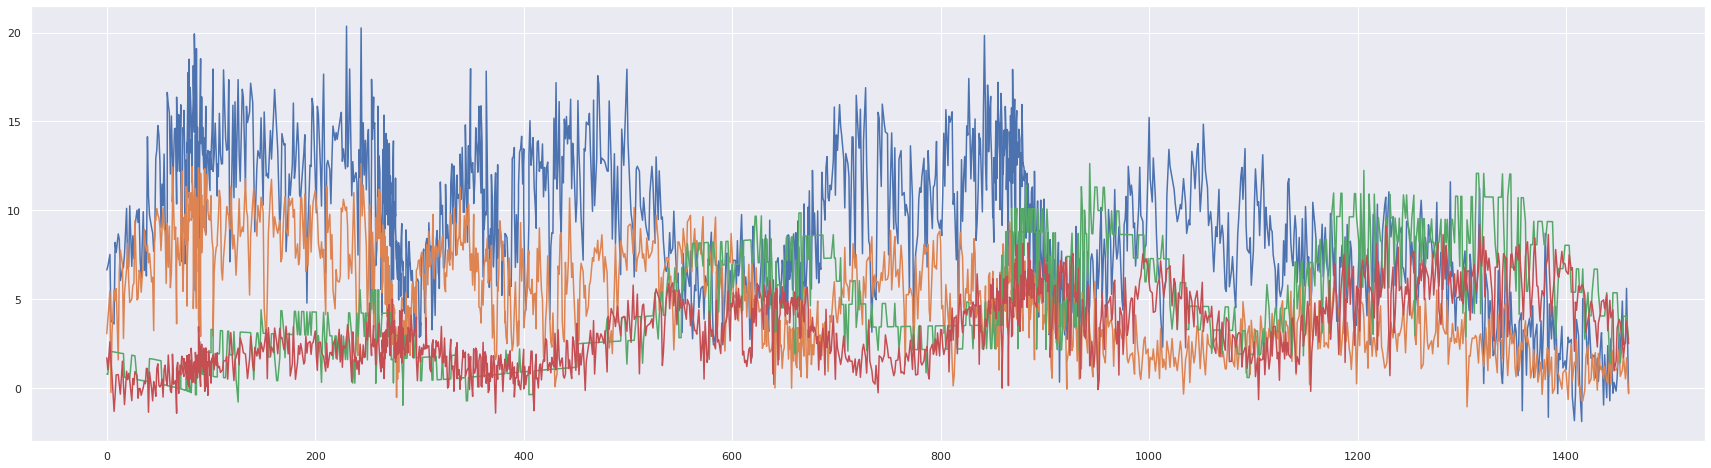

In [15]:
my_augmenter = (
                TimeWarp(n_speed_change=20, max_speed_ratio=5) # random time warping
                #+ Crop(size=100)  # random crop subsequences with length 300
                + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
                + Drift(max_drift=(0.1, 0.3)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
                #+ Reverse() @ 0.5  # with 50% probability, reverse the sequence
                + AddNoise()
                )
# Build a pipeline of augmenters 
Y_aug1, X_aug = my_augmenter.augment(Y1, X)
Y_aug2, X_aug = my_augmenter.augment(Y2, X)
Y_aug3, X_aug = my_augmenter.augment(Y3, X)
Y_aug4, X_aug = my_augmenter.augment(Y4, X)

plt.plot(X_aug, Y_aug1)
plt.plot(X_aug, Y_aug2)
plt.plot(X_aug, Y_aug3)
plt.plot(X_aug, Y_aug4)

In [16]:
train_df['광진구'] = Y_aug1
train_df['동대문구'] = Y_aug2
train_df['성동구'] = Y_aug3
train_df['중랑구'] = Y_aug4

In [17]:
train_df

,일시,광진구,동대문구,성동구,중랑구
0,20180101,6.642501,3.055621,0.787126,1.698362
1,20180102,6.839461,3.860050,0.772375,1.029031
2,20180103,7.515765,5.447106,2.073791,2.600768
3,20180104,3.730557,-0.251551,2.059180,1.523595
4,20180105,3.744076,3.136433,2.044638,0.714430
...,...,...,...,...,...
1456,20211227,4.889267,1.002343,2.721665,2.598758
1457,20211228,2.422623,1.792516,4.036627,1.706317
1458,20211229,2.535164,0.515772,4.035500,2.860370
1459,20211230,5.606449,1.696279,4.034382,3.756776


## Seasonal Decompose

In [ ]:
from datetime import datetime

train['일시'] = train.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
train.set_index('일시', inplace=True)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def func_diff(location, lamb):
    # 계절성 제거
    result = seasonal_decompose(train['{}'.format(location)], model='additive')
    result = result.observed
    
    # 추세 변동요인 추출 - trend
    cycle, trend = sm.tsa.filters.hpfilter(result, lamb)
    data_불규칙 = pd.DataFrame(cycle)

    # 불규칙 변동요인 제거한 순환변동요인 추출 - cycle2
    unrule, cycle2 = sm.tsa.filters.hpfilter(data_불규칙, lamb)

    # 표준화
    cycle_std = (cycle2-np.mean(cycle2))/np.std(cycle2)

    train['cycle_{}'.format(location)] = cycle_std
    train['unrule_{}'.format(location)] = unrule
    train['trend_{}'.format(location)] = trend

In [ ]:
func_diff('광진구', 14400) #129600
func_diff('동대문구', 14400)
func_diff('성동구', 14400)
func_diff('중랑구', 14400)

In [ ]:
train = train.reset_index()
train['일시'] = train['일시'].astype(str)

## Train / Validation Split

In [18]:
val_df = train_df.iloc[1096-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train_df.iloc[:1096].reset_index().drop(columns='index') # 20180101 ~ 20201231

In [19]:
train_df.shape, val_df.shape

((1096, 5), (368, 5))

## Data Pre-processing

In [20]:
# 광진구, 동대문구, 성동구, 중랑구

def get_x_y_data_feature(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구', '광진구_aug',
                                          'cycle_동대문구', 'unrule_동대문구', 'trend_동대문구', '동대문구_aug',
                                          'cycle_성동구', 'unrule_성동구', 'trend_성동구', '성동구_aug',
                                          'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구', '중랑구_aug']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [21]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [22]:
train_df = make_ymd_feature(train_df)
val_df = make_ymd_feature(val_df)

In [23]:
train_x_1, train_y_1 = get_x_y_data_feature(train_df)

  0%|          | 0/1093 [00:00<?, ?it/s]

In [24]:
val_x_1, val_y_1 = get_x_y_data_feature(val_df)

  0%|          | 0/365 [00:00<?, ?it/s]

In [25]:
train_x_1[0].shape

(1093, 365, 1093, 365)

## CustomDataset

In [26]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [27]:
train_dataset_1 = CustomDataset(train_x_1, train_y_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0, drop_last=True)

val_dataset_1 = CustomDataset(val_x_1, val_y_1)
val_loader_1 = DataLoader(val_dataset_1, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0, drop_last=True)

In [28]:
train_dataset_1[0][0].shape, train_dataset_1[0][1].shape

(tensor([[2.0180, 0.0833, 0.0323, 6.6425, 3.0556, 0.7871, 1.6984],
         [2.0180, 0.0833, 0.0645, 6.8395, 3.8601, 0.7724, 1.0290],
         [2.0180, 0.0833, 0.0968, 7.5158, 5.4471, 2.0738, 2.6008]]),
 tensor([ 3.7306, -0.2516,  2.0592,  1.5236]))

## Define Model

In [29]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=23, hidden_size=256, num_layers=1, batch_first=True)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:, -1,:])
        return output

## Train

In [30]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model
    return best_model

In [31]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [32]:
model = BaseModel()

In [33]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader_1, val_loader_1, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [4.38840] Val MAE : [5.24728]
Epoch : [2] Train Loss : [2.48915] Val MAE : [35.18985]
Epoch : [3] Train Loss : [1.96839] Val MAE : [85.03501]
Epoch : [4] Train Loss : [1.84292] Val MAE : [63.15609]
Epoch : [5] Train Loss : [1.81800] Val MAE : [131.72665]
Epoch : [6] Train Loss : [1.81289] Val MAE : [223.29004]
Epoch : [7] Train Loss : [1.82111] Val MAE : [455.47963]
Epoch : [8] Train Loss : [1.77169] Val MAE : [546.25140]
Epoch : [9] Train Loss : [1.77494] Val MAE : [771.15358]
Epoch : [10] Train Loss : [1.80103] Val MAE : [1283.15507]
Epoch : [11] Train Loss : [1.81081] Val MAE : [2038.20732]
Epoch : [12] Train Loss : [1.81117] Val MAE : [2104.28621]
Epoch : [13] Train Loss : [1.77789] Val MAE : [1319.57190]
Epoch : [14] Train Loss : [1.72604] Val MAE : [1249.79976]
Epoch : [15] Train Loss : [1.70407] Val MAE : [1303.44226]
Epoch : [16] Train Loss : [1.75406] Val MAE : [678.24150]
Epoch : [17] Train Loss : [1.72407] Val MAE : [965.95079]
Epoch    17: reducing 

## Inference

In [ ]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [34]:
test_df = pd.read_csv('data/sample_submission.csv')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')

In [35]:
test_df.head()

,년,월,일,광진구,동대문구,성동구,중랑구
0,2.021,1.000000,0.935484,5.721926,3.052695,3.087450,2.539787
1,2.021,1.000000,0.967742,5.713021,3.038360,2.660053,2.689268
2,2.021,1.000000,1.000000,5.216139,3.023978,1.806339,2.168853
3,2.022,0.083333,0.032258,0.000000,0.000000,0.000000,0.000000
4,2.022,0.083333,0.064516,0.000000,0.000000,0.000000,0.000000


In [36]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구', '광진구_aug',
                   'cycle_동대문구', 'unrule_동대문구', 'trend_동대문구', '동대문구_aug',
                   'cycle_성동구', 'unrule_성동구', 'trend_성동구', '성동구_aug',
                   'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구', '중랑구_aug']] = model_pred
                                    
    return df.loc[CFG['X_RANGE']:, ['cycle_광진구', 'unrule_광진구', 'trend_광진구', '광진구_aug',
                                    'cycle_동대문구', 'unrule_동대문구', 'trend_동대문구', '동대문구_aug',
                                    'cycle_성동구', 'unrule_성동구', 'trend_성동구', '성동구_aug',
                                    'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구', '중랑구_aug']].reset_index().drop(columns=['index'])

In [37]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Main Model

In [ ]:
CFG = {
    'X_RANGE': 7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-2,
    'BATCH_SIZE': 128,
    'SEED': 42
}

In [ ]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [ ]:
train_x, train_y = get_x_y_data(train_df)
val_x, val_y = get_x_y_data(val_df)

In [ ]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0, drop_last=True)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0, drop_last=True)

In [ ]:
train_dataset[0][0].shape, train_dataset[0][1].shape

In [ ]:
from torch.nn import Transformer
from torch import nn
import torch
import math

class TFModel(nn.Module):
    def __init__(self, iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )

        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        )

        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=896, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=4),
        )

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0] # 128*7
        output = output.reshape(1, -1)
        output = self.multioutput_reg(output)
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [ ]:
def trainTF(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
            result = model(X.float().to(device), src_mask)
            
            loss = criterion(result, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model
    return best_model

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
            result = model(X.float().to(device), src_mask)
            
            loss = criterion(result, Y)
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

In [ ]:
model = TFModel(365*3, 365, 256, 8, 4, 0.1)

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_model = trainTF(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

In [ ]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
            model_pred = model(X, src_mask)
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']] = model_pred
    return df.loc[CFG['X_RANGE']:, ['광진구', '동대문구', '성동구', '중랑구']].reset_index().drop(columns=['index'])

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

preds = inference(best_model, test_df, device)

In [ ]:
preds

## Submission

In [38]:
submit = pd.read_csv('data/sample_submission.csv')
submit.head()

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [39]:
submit['광진구'] = preds['광진구'].round(3)
submit['동대문구'] = preds['동대문구'].round(3)
submit['성동구'] = preds['광진구'].round(3)
submit['중랑구'] = preds['동대문구'].round(3)

In [40]:
submit

,일시,광진구,동대문구,성동구,중랑구
0,20220101,5.192,3.185,5.192,3.185
1,20220102,5.068,3.121,5.068,3.121
2,20220103,4.966,3.010,4.966,3.010
3,20220104,4.998,3.103,4.998,3.103
4,20220105,5.011,3.099,5.011,3.099
...,...,...,...,...,...
329,20221126,5.701,3.397,5.701,3.397
330,20221127,5.871,3.382,5.871,3.382
331,20221128,5.975,3.381,5.975,3.381
332,20221129,6.054,3.372,6.054,3.372


<AxesSubplot:>

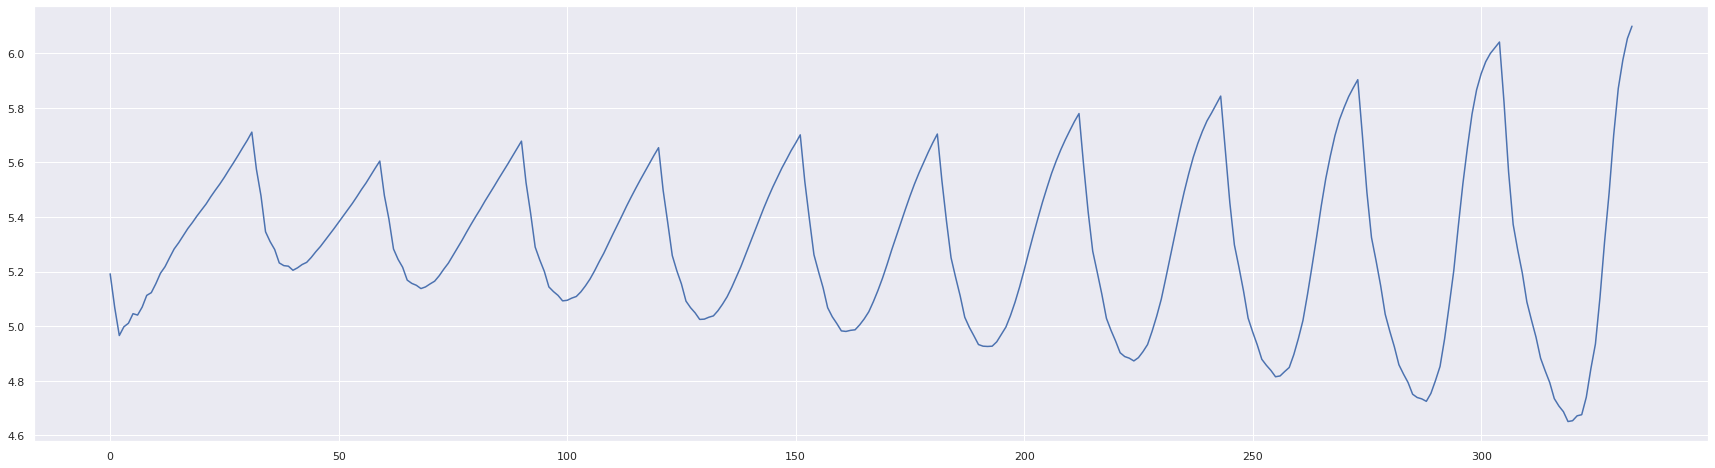

In [41]:
submit['광진구'].plot()

<AxesSubplot:>

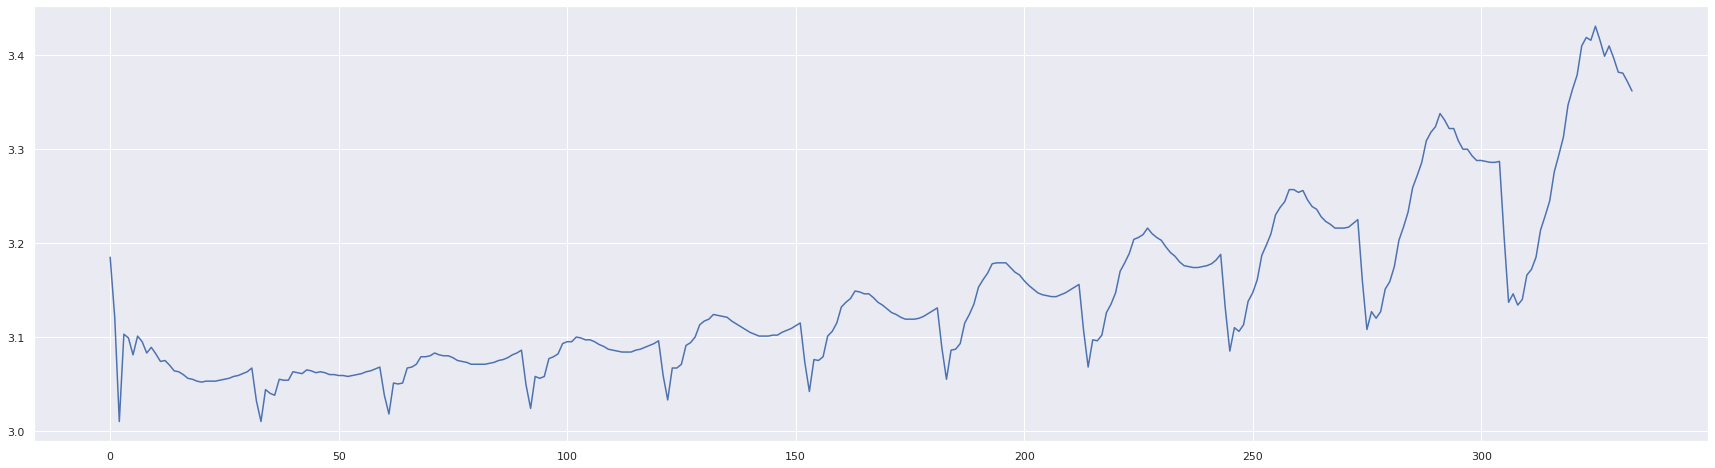

In [42]:
submit['동대문구'].plot()

<AxesSubplot:>

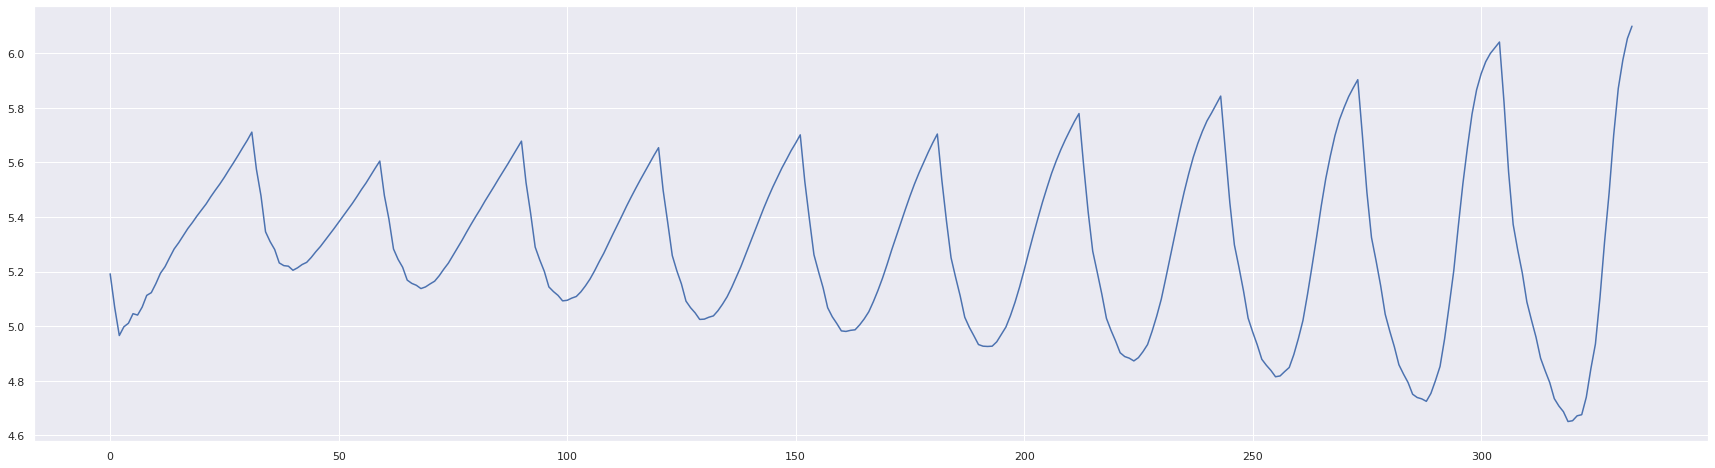

In [43]:
submit['성동구'].plot()

<AxesSubplot:>

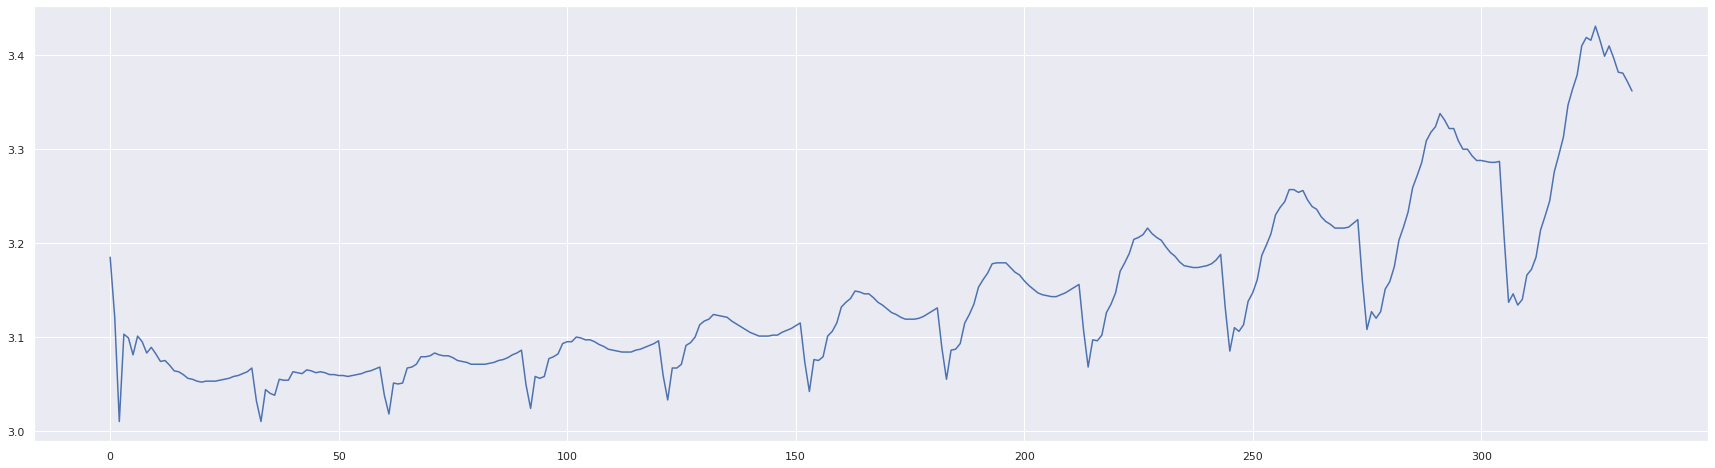

In [44]:
submit['중랑구'].plot()

In [46]:
submit.to_csv('submission/submit_1129.csv', index=False)